<a href="https://colab.research.google.com/github/kennethgoodman/Columbia-E4579/blob/main/image_generation_pipelines/dalle_mini_Inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 53 kB 734 kB/s 
     |████████████████████████████████| 235 kB 85.9 MB/s 
     |████████████████████████████████| 1.8 MB 57.7 MB/s 
     |████████████████████████████████| 4.7 MB 60.5 MB/s 
     |████████████████████████████████| 197 kB 70.8 MB/s 
     |████████████████████████████████| 180 kB 81.2 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 1.0 MB 79.0 MB/s 
     |████████████████████████████████| 145 kB 78.7 MB/s 
     |████████████████████████████████| 217 kB 71.3 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 76 kB 3.6 MB/s 
     |████████████████████████████████| 6.6 MB 70.7 MB/s 
     |████████████████████████████████| 101 kB 9.5 MB/s 
     |████████████████████████████████| 157 kB 69.8 MB/s 
     |████████████████████████████████| 181 kB 91.4 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |█████████████████

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:1:57.4
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmpeutomrxj:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBart

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:35.4


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:
# number of predictions per prompt
n_predictions = 6

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [ ]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False

outputs_path = "/content/gdrive/MyDrive/AI/DalleMini/samples" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")
import os
os.makedirs(outputs_path, exist_ok=True)


Mounted at /content/gdrive
Outputs will be saved to /content/gdrive/MyDrive/AI/DalleMini/samples


In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
from flax.training.common_utils import shard

def get_encode_images(tokenized_prompt, subkey):
  return p_generate(
      tokenized_prompt,
      shard_prng_key(subkey),
      params,
      gen_top_k,
      gen_top_p,
      temperature,
      cond_scale,
  )

def remove_bos(encoded_images):
  return encoded_images.sequences[..., 1:]

def decode_images(encoded_images):
  images = []
  decoded_images = p_decode(encoded_images, vqgan_params)
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
  for decoded_img in decoded_images:
      img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
      images.append(img)
  return images

def save_images(images, prompt):
  for img in images:
    base_count = len(os.listdir(outputs_path))
    os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{base_count}.png')

def saving_images_with_scores(images_with_scores, prompt, top_k=2):
  for i, (img, score) in enumerate(images_with_scores[:top_k]):
    base_count = len(os.listdir(outputs_path))
    os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{i}.{score}.png')

def display_images(images):
  for img in images:
    display(img)
    print()

def display_images_with_scores(images_with_scores):
  for (img, score) in images_with_scores:
    display(img)
    print(f"Score: {score:.2f}\n")

def get_tokenized_prompt(prompt):
  tokenized_prompt = processor(prompt)
  return replicate(tokenized_prompt)

def get_images(key, prompts):
  images = []
  tokenized_prompt = get_tokenized_prompt(prompts)
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images and remove BOS
      encoded_images = remove_bos(get_encode_images(tokenized_prompt, subkey))
      # decode images
      images.extend(decode_images(encoded_images))
  return images


def get_logits(images):
  # get clip scores
  clip_inputs = clip_processor(
      text=prompts * jax.device_count(),
      images=images,
      return_tensors="np",
      padding="max_length",
      max_length=77,
      truncation=True,
  ).data
  logits = p_clip(shard(clip_inputs), clip_params)
  return logits      


def rank_images(images, prompts):
  logits = get_logits(images)
  prompts_to_images_with_score = {}
  p = len(prompts)
  logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()
  for i, prompt in enumerate(prompts):
      prompts_to_images_with_score[prompt] = []
      to_argsort = logits[i] if p > 1 else logits
      for idx in to_argsort.argsort()[::-1]:
          new_image = images[idx * p + i]
          score = jnp.asarray(to_argsort[idx], dtype=jnp.float32)
          prompts_to_images_with_score[prompt].append((new_image, score))
  return prompts_to_images_with_score



Prompts: ['in the beginning there was nothing, only darkness', 'bacteria under a microscope']



  0%|          | 0/2 [00:00<?, ?it/s]

Doing: in the beginning there was nothing, only darkness


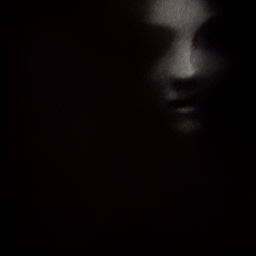

Score: 26.05



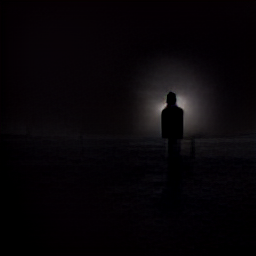

Score: 25.66

Doing: bacteria under a microscope


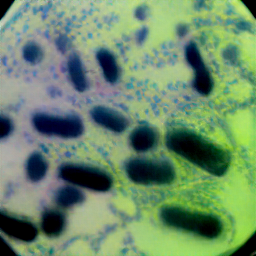

Score: 30.86



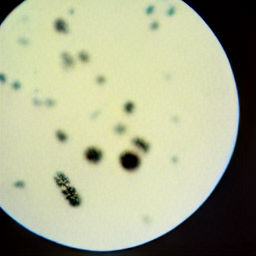

Score: 30.08



In [ ]:
prompts = [
    "in the beginning there was nothing, only darkness",
    "bacteria under a microscope",
    
]

print(f"Prompts: {prompts}\n")
# generate images
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)
images = get_images(key, prompts)
ranked_images = rank_images(images, prompts)
for prompt in prompts:
  print(f"Doing: {prompt}")
  display_images_with_scores(ranked_images[prompt])
  saving_images_with_scores(ranked_images[prompt])

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    tmp_ranked_images = ranked_images[prompt]
    
    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for (img, _) in tmp_ranked_images])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

wandb: Currently logged in as: kgoodman. Use `wandb login --relogin` to force relogin


Click on the link above to check out your generated images.